# Notebook 7: Allostery

How should we define allostery? The most common definition is **cooperative allostery**. Suppose we have a protein with two binding sites on distance sides of the protein.

&nbsp;

<p align="center">
  <img src="../figures/cooperativity.svg" alt="drawing" width="400"/>
</p>


Copperativity, is defined as,

$$\Delta \Delta G = (G_{10} - G_{00}) - (G_{11} - G_{01})$$

where $G_{10}, G_{00}, G_{11}, G_{01}$ represent the free energies of states 10, 00, 11, 01 repsectively.

If $\Delta\Delta G \neq 0$ it means the binding energy of ligand to the first binding site depend on whether ligand is bound at the distant second site -- **Allostery**. In this work shop we will used the energy $E$ as a substitute for the free energy $G$. Technically, $E = G$ at zero temperature. 

Our method to compute allostery in our elastic network will be to:
1. Define active site on left side of network.
2. Define allosteric site  on right side of network.
3. Apply displacement to the active site and measure the energy $E_{10}$.
4. Apply displacement to the allosteric site and measure the energy $E_{01}$.
5. Apply displacements to both the active and allosteric site and measure the energy $E_{11}$
6. Compute allostery by $\Delta\Delta E = E_{01} + E_{10} - E_{11}$. $(E_{00} = 0)$

In [1]:
using Revise, LinearAlgebra, PyPlot, LaTeXStrings
push!(LOAD_PATH, "../src/")
using Elastic_N3, Elastic_N4, Elastic_N5, Elastic_N6

┌ Info: Precompiling Elastic_N6 [top-level]
└ @ Base loading.jl:1664


In [2]:
W = 10 # width of network
L = 10 # length of network
q = 5 # number of node types
disorder = 0.15 # spatial disorder added to structure
k_min = 1e-2 # softest spring constant in interaction table
k_max = 1e1 # stiffest spring constant in interaction table

# build our network components
r, A = buildStructure(W, L, disorder)
seq = rand(1:q, W*L)
K = buildSpringTable(q, k_min, k_max)
S = seq2Springs(seq, K, A);
H = computeHessian(r, S);
net = Network(seq, r, S, H);

In [3]:
# defined active site and allosteric site
actSiteNodes = collect(Int(floor(W/2)-1) : Int(floor(W/2))+2)
allSiteNodes = W*L .- actSiteNodes .+ 1

@show actSiteNodes
@show allSiteNodes;

actSiteNodes = [4, 5, 6, 7]
allSiteNodes = [97, 96, 95, 94]


In [4]:
# get inidices of active and allosteric site nodes.
actSite = sort([actSiteNodes * 2; actSiteNodes * 2 .- 1])
allSite = sort([allSiteNodes * 2; allSiteNodes * 2 .- 1])

@show actSite
@show allSite;

actSite = [7, 8, 9, 10, 11, 12, 13, 14]
allSite = [187, 188, 189, 190, 191, 192, 193, 194]


### Here is a little function to automate making random strains for binding sites.

In [5]:
function makeRandStrain(site, r)
    # generate a random strain,
    # rotations and translations and normalize.
    strain = randn(length(site))
    removeTranslationRotation!(strain, r[site])
    normalize!(strain)
    return strain
end

makeRandStrain (generic function with 1 method)

In [6]:
actStrain = makeRandStrain(actSite, r)
allStrain = makeRandStrain(allSite, r)

8-element Vector{Float64}:
  0.3837884139344799
  0.03196754350460796
 -0.31616981556839036
  0.3433245569797522
 -0.39048253623954454
 -0.5792514715273311
  0.3228639378734549
  0.20395937104297104

### Plot the strains at the active and allosteric sites.

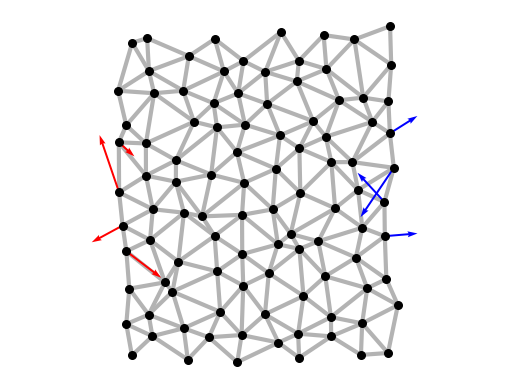

In [7]:
fig, ax = subplots()
plotNetwork!(ax,r, A)

dr_act = zeros(length(r))
dr_act[actSite] = actStrain
plotDisplacment!(ax,r, dr_act, color="red", scale=0.4)

dr_all = zeros(length(r))
dr_all[allSite] = allStrain
plotDisplacment!(ax,r, dr_all, color="blue", scale=0.4)

### To measure allostery we need to measure energies, let's define a function for this.

In [11]:
function computeEnergy(net::Network, strain, site)
    E, F, Δr = computeResponse(net.r, net.H, strain, site)
    return E
end

@show computeEnergy(net, actStrain, actSite)
@show computeEnergy(net, allStrain, allSite);

computeEnergy(net, actStrain, actSite) = 0.39740256431883675
computeEnergy(net, allStrain, allSite) = 1.0479927346983051


### Next lets define a function to compute allostery from the three energies $E_{10}, E_{01}, E_{11}$

In [12]:
cooperativity(E10, E01, E11) = E10 + E01 - E11

cooperativity (generic function with 1 method)

### Now lets pack the strains and sites for the three different binding conditions into a list.

In [13]:
sites =  fill([actSite; allSite], 3)

3-element Vector{Vector{Int64}}:
 [7, 8, 9, 10, 11, 12, 13, 14, 187, 188, 189, 190, 191, 192, 193, 194]
 [7, 8, 9, 10, 11, 12, 13, 14, 187, 188, 189, 190, 191, 192, 193, 194]
 [7, 8, 9, 10, 11, 12, 13, 14, 187, 188, 189, 190, 191, 192, 193, 194]

In [14]:
strains =  [ [actStrain; zeros(8)], [zeros(8); allStrain], [actStrain; allStrain]]
hcat(strains...)

16×3 Matrix{Float64}:
  0.40879    0.0         0.40879
 -0.310767   0.0        -0.310767
 -0.362372   0.0        -0.362372
 -0.196587   0.0        -0.196587
 -0.229531   0.0        -0.229531
  0.672864   0.0         0.672864
  0.183113   0.0         0.183113
 -0.16551    0.0        -0.16551
  0.0        0.383788    0.383788
  0.0        0.0319675   0.0319675
  0.0       -0.31617    -0.31617
  0.0        0.343325    0.343325
  0.0       -0.390483   -0.390483
  0.0       -0.579251   -0.579251
  0.0        0.322864    0.322864
  0.0        0.203959    0.203959

### Write helper function to builds sites for allostery and generate random strains

In [15]:
function prepareAllosterySitesStrains(W, L, r)
    # build sites and strains vectors for computing allostery.
    actSiteNodes = collect(Int(floor(W/2)-1) : Int(floor(W/2))+2)
    allSiteNodes = W*L .- actSiteNodes .+ 1
    actSite = sort([actSiteNodes * 2; actSiteNodes * 2 .- 1])
    allSite = sort([allSiteNodes * 2; allSiteNodes * 2 .- 1])
    actStrain = makeRandStrain(actSite, r)
    allStrain = makeRandStrain(allSite, r)
    sites =  fill([actSite; allSite], 3)
    strains =  [ [actStrain; zeros(8)], [zeros(8); allStrain], [actStrain; allStrain]]
    return sites, strains
end

sites, strains = prepareAllosterySitesStrains(W, L, net.r)
sites

3-element Vector{Vector{Int64}}:
 [7, 8, 9, 10, 11, 12, 13, 14, 187, 188, 189, 190, 191, 192, 193, 194]
 [7, 8, 9, 10, 11, 12, 13, 14, 187, 188, 189, 190, 191, 192, 193, 194]
 [7, 8, 9, 10, 11, 12, 13, 14, 187, 188, 189, 190, 191, 192, 193, 194]

In [16]:
hcat(strains...)

16×3 Matrix{Float64}:
  0.0586953   0.0         0.0586953
 -0.451915    0.0        -0.451915
 -0.149443    0.0        -0.149443
  0.30832     0.0         0.30832
  0.168168    0.0         0.168168
 -0.489606    0.0        -0.489606
 -0.0774207   0.0        -0.0774207
  0.633202    0.0         0.633202
  0.0         0.0713997   0.0713997
  0.0         0.611042    0.611042
  0.0        -0.274725   -0.274725
  0.0        -0.0585493  -0.0585493
  0.0         0.412607    0.412607
  0.0         0.0203682   0.0203682
  0.0        -0.209282   -0.209282
  0.0        -0.572861   -0.572861

### Since we will be evolving network under a selective pressure for cooperativity let's define a function that computes a networks allosteric "fitness".

In [17]:
function computeFitness(net::Network, strains, sites)
    # compute the allosteric fitness for a network.
    E10 = computeEnergy(net, strains[1], sites[2])
    E01 = computeEnergy(net, strains[2], sites[2])
    E11 = computeEnergy(net, strains[3], sites[3])
    fitness = cooperativity(E10, E01, E11)
    return fitness
end

computeFitness (generic function with 1 method)

In [18]:
computeFitness(net, strains, sites)

-0.008878646447422867

In [19]:
W = 10 # width of network
L = 10 # length of network
q = 5 # number of node types
disorder = 0.15 # spatial disorder added to structure
k_min = 1e-2 # softest spring constant in interaction table
k_max = 1e1 # stiffest spring constant in interaction table

net, K = buildNetworkAndTable(W, L, q, disorder, k_min, k_max)
sites, strains = prepareAllosterySitesStrains(W, L, net.r)

fitness = computeFitness(net, strains, sites)

-0.0019159563867748863

### Measure cooperativity of 1000 random networks, (~1min)

In [20]:
n = 1000
W, L = 7,7
coops1 = zeros(n)
for i in 1:n
    net, K = buildNetworkAndTable(W, L, q, disorder, k_min, k_max)
    sites, strains = prepareAllosterySitesStrains(W, L, net.r)
    coops1[i] = computeFitness(net, strains, sites)
end

W, L = 20,20
coops2 = zeros(n)
for i in 1:n
    net, K = buildNetworkAndTable(W, L, q, disorder, k_min, k_max)
    sites, strains = prepareAllosterySitesStrains(W, L, net.r)
    coops2[i] = computeFitness(net, strains, sites)
end

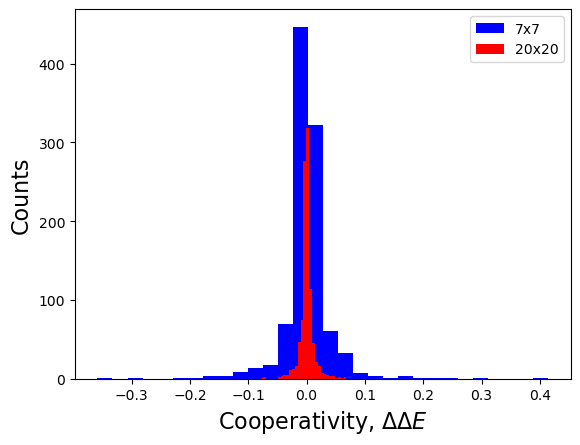

In [21]:
fig, ax = subplots()
ax.hist(coops1, 30, color="blue")
ax.hist(coops2, 30, color="red")
ax.set_xlabel("Cooperativity, "*L"\Delta\Delta E", fontsize=16)
ax.set_ylabel("Counts", fontsize=16)
ax.legend(["7x7","20x20"]);